# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

# [作業目標]
- 依照下列提示與引導, 以幾種不同的方式, 檢視可能的離群值

# [作業重點]
- 從原始資料篩選可能的欄位, 看看那些欄位可能有離群值 (In[3], Out[3])
- 繪製目標值累積密度函數(ECDF)的圖形, 和常態分布的累積密度函數對比, 以確認是否有離群值的情形 (In[6], Out[6], In[7], Out[7])

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 設定 data_path
dir_data = './data/'

In [2]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: ./data/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

In [20]:
# 觀察
app_train.dtypes.value_counts()
app_train_float = app_train.select_dtypes(include='int64')
app_train_int = app_train.select_dtypes(include='float64')
app_train_int.describe()


float64    65
int64      41
object     16
dtype: int64

In [25]:
# 先篩選數值型的欄位 :因為數值型才有可能找出範圍來判斷 outliner!!

app_train_num = app_train.select_dtypes(include=['int64','float64']).columns

numeric_columns = list(app_train.columns[list(app_train.dtypes.isin(app_train_num))])

# 再把只有 2 值 (通常是 0,1) 的欄位去掉
numeric_columns = list(app_train[numeric_columns].columns[list(app_train[numeric_columns].apply(lambda x:len(x.unique())!=2 ))])
print("Numbers of remain columns %i " % len(numeric_columns))

# 檢視這些欄位的數值範圍
for col in numeric_columns:
    plt.boxplot(app_train[col])
    plt.show()

Numbers of remain columns 0 


(array([5.3501e+04, 3.4636e+04, 1.0248e+04, 2.3360e+03, 4.8600e+02,
        3.0000e+01, 8.0000e+00, 3.3350e+03, 0.0000e+00, 2.0000e+00]),
 array([ 0. ,  9.1, 18.2, 27.3, 36.4, 45.5, 54.6, 63.7, 72.8, 81.9, 91. ]),
 <BarContainer object of 10 artists>)

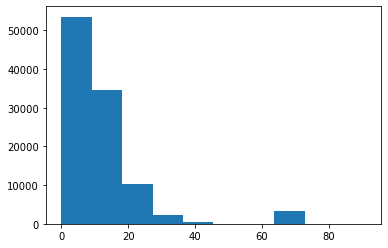

In [3]:
a = app_train['OWN_CAR_AGE'].dropna()
plt.hist(a)

In [ ]:
# 從上面的圖檢查的結果，至少這三個欄位好像有點可疑

# AMT_INCOME_TOTAL
# REGION_POPULATION_RELATIVE
# OBS_60_CNT_SOCIAL_CIRCLE

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

經驗分布函數（empirical distribution function）是統計學中一個與樣本經驗測度有關的分布函數。該累積分布函數是在所有n個數據點上都跳躍1/n的階躍函數。
* 對被測變量的某個值而言，該值的分布函數值表示所有觀測樣本中小於或等於該值的樣本所占的比例。

經驗分布函數是對用於生成樣本的累積分布函數的估計。根據Glivenko–Cantelli定理可以證明，經驗分布函數以概率1收斂至這一累積分布函數。

hist, bin_edges = histogram(b_oz, normed=True) 是频率图
plot(np.cumsum(hist))

In [10]:
cdf = app_train.AMT_INCOME_TOTAL.value_counts().sort_index().cumsum()
# :agg後的uniq薪水(.value_counts())按小到大順序(.sort_index())累加(.cumsum())
cdf.index     # X :欄位是薪水值
cdf/cdf.max() # Y 轉比例

25650.0        0.000007
26100.0        0.000016
26460.0        0.000020
26550.0        0.000026
27000.0        0.000241
                 ...   
6750000.0      0.999987
9000000.0      0.999990
13500000.0     0.999993
18000090.0     0.999997
117000000.0    1.000000
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: float64

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


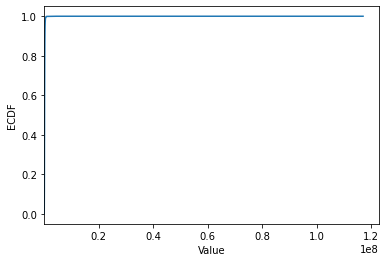

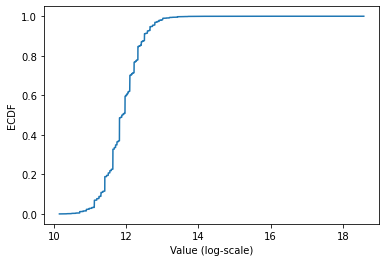

In [5]:
# 最大值離平均與中位數很遠
print(app_train['AMT_INCOME_TOTAL'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)

cdf = app_train.AMT_INCOME_TOTAL.value_counts().sort_index().cumsum()
plt.plot(list(cdf.index), cdf/cdf.max())

plt.xlabel('Value')
plt.ylabel('ECDF')

plt.xlim([cdf.index.min(), cdf.index.max() * 1.05]) # 限制顯示圖片的範圍
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

# 改變 y 軸的 Scale, 讓我們可以正常檢視 ECDF
plt.plot(np.log(list(cdf.index)), cdf/cdf.max())
plt.xlabel('Value (log-scale)')
plt.ylabel('ECDF')

plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

## ↑可看出非常態分佈

## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64


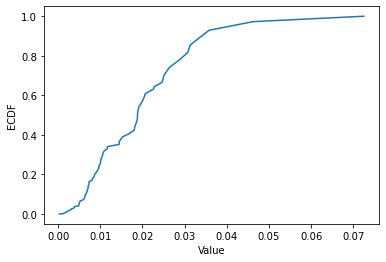

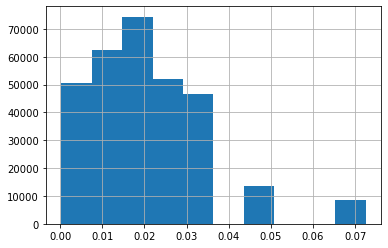

0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
            ...  
0.001417      467
0.001333      235
0.000533       39
0.000938       28
0.000290        2
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64

In [11]:
# 最大值落在分布之外
print(app_train['REGION_POPULATION_RELATIVE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)

cdf = app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index().cumsum()
plt.plot(list(cdf.index), cdf/cdf.max())

plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['REGION_POPULATION_RELATIVE'].hist()
plt.show()

app_train['REGION_POPULATION_RELATIVE'].value_counts()

# 就以這個欄位來說，雖然有資料掉在分布以外，也不算異常，僅代表這間公司在稍微熱鬧的地區有的據點較少，
# 導致 region population relative 在少的部分較為密集，但在大的部分較為疏漏

count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64


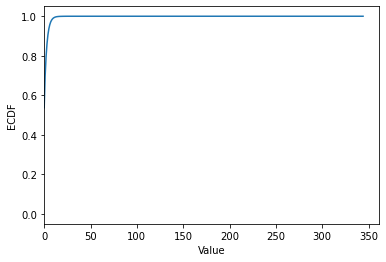

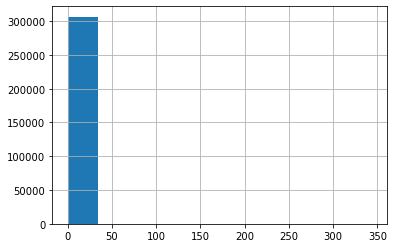

344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64


In [12]:
# 最大值落在分布之外
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)

cdf = app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index().cumsum()
plt.plot(list(cdf.index), cdf/cdf.max())

plt.xlabel('Value')
plt.ylabel('ECDF')

plt.xlim([cdf.index.min() * 0.95, cdf.index.max() * 1.05])
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

app_train['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()

print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False))

## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值

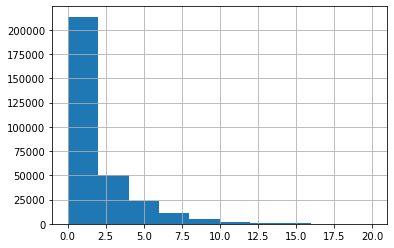

In [19]:
# 把一些極端值暫時去掉，在繪製一次 Histogram
# 選擇 OBS_60_CNT_SOCIAL_CIRCLE 小於 20 的資料點繪製

app_train[app_train.OBS_60_CNT_SOCIAL_CIRCLE <= 20]['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()